## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [55]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')


In [56]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [57]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
short_rolling.head(20)

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
long_rolling.tail()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2017-12-18,8.838745e+11,8.205358e+10,2.004618e+11,9.121964e+10,2.119183e+11,2.171943e+11,1.547477e+11,1.591236e+11,1.224074e+11,9.905482e+10,...,8.595350e+10,2.143569e+11,1.993963e+11,3.782232e+10,2.170649e+11,1.032860e+11,2.191914e+11,1.980349e+11,2.632599e+11,3.175335e+11
2017-12-19,8.838339e+11,8.194964e+10,1.999398e+11,9.101286e+10,2.112738e+11,2.174574e+11,1.544956e+11,1.585014e+11,1.219904e+11,9.891594e+10,...,8.599374e+10,2.143661e+11,1.992039e+11,3.781833e+10,2.171336e+11,1.032689e+11,2.190592e+11,1.979785e+11,2.625456e+11,3.174101e+11
2017-12-20,8.841265e+11,8.185459e+10,1.996123e+11,9.087142e+10,2.110345e+11,2.180210e+11,1.543482e+11,1.580662e+11,1.216891e+11,9.883611e+10,...,8.610362e+10,2.143457e+11,1.990828e+11,3.782512e+10,2.172607e+11,1.031769e+11,2.191049e+11,1.980953e+11,2.621450e+11,3.175706e+11
2017-12-21,8.834296e+11,8.169818e+10,1.990140e+11,9.055528e+10,2.106797e+11,2.183311e+11,1.541031e+11,1.574215e+11,1.212432e+11,9.870726e+10,...,8.608761e+10,2.142183e+11,1.988803e+11,3.782159e+10,2.171597e+11,1.028897e+11,2.189438e+11,1.981198e+11,2.615109e+11,3.174317e+11
2017-12-22,8.825079e+11,8.150679e+10,1.983299e+11,9.017021e+10,2.102252e+11,2.185470e+11,1.537247e+11,1.566720e+11,1.207682e+11,9.853931e+10,...,8.601122e+10,2.140545e+11,1.986375e+11,3.779888e+10,2.169200e+11,1.025996e+11,2.186951e+11,1.980101e+11,2.608246e+11,3.170569e+11


### Plot three years of AAPL stock:

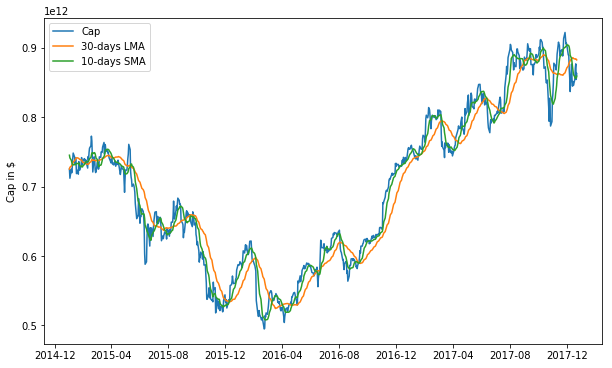

In [59]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days LMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 
(This model provides a framework for understanding how a portfolio value evolves over time with both deterministic (mean-reversion) and stochastic (random noise) components.)

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$


Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they be can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


## Benefits of Using Moving Averages as Signals
1. Trend Identification: Smooths data to highlight trends.
2. Signal Generation: Provides clear buy and sell signals.
3. Reducing Volatility: Filters out market noise.
4. Combining with Other Indicators: Enhances multi-factor models.
5. Customization and Flexibility: Adjustable parameters for tailored strategies.
6. Historical Performance Analysis: Enables backtesting and optimization.
6. Risk Management: Helps in managing risk and setting stop-loss levels.

    By incorporating moving average signals, you can enhance the performance, stability, and robustness of trading and investment models.

### Data Preparation

In [60]:
#Calculate Average Market Capitalization
average_market_cap = df_cap.sum(axis=1).mean() 

# Normalize Rolling Averages and original cap
short_rolling_average = short_rolling / average_market_cap
long_rolling_average = long_rolling / average_market_cap
df_cap_average = df_cap / average_market_cap

#Divide the normalized rolling averages by their values at the first valid index to set the initial value to 1. 
# This allows the series to be compared relative to its initial value. 
#This standardization simplifies visual comparisons and calculations, particularly when dealing with multiple series
# with different starting values or scales.
short_rolling_average_first_valid = (short_rolling_average 
                                    /
                                    short_rolling_average.loc[ short_rolling_average.first_valid_index() ])
long_rolling_average_first_valid = (long_rolling_average
                                   /
                                   long_rolling_average.loc[ long_rolling_average.first_valid_index() ])


# De-mean Rolling Averages
# Calculating percentage changes and shifting aligns the percentage changes with their periods, 
# providing a view of the relative changes over time.
# Demeaning helps to highlight deviations and short-term dynamics by removing 
# the trend component, making it easier to analyze the inherent fluctuations 
# and changes in the time series data
short_rolling_demeaned = short_rolling_average_first_valid.pct_change(periods=1).shift(-1)
long_rolling_demeaned = long_rolling_average_first_valid.pct_change(periods=1).shift(-1)

### Data Cleaning

In [61]:
# Drop last row
# It removes the last row from the DataFrame to address alignment issues and 
# ensure consistent data length.
market_cap = df_cap_average[:-1]

# Drop not-a-numbers rows
signal_1 = short_rolling_demeaned.copy()
signal_2 = long_rolling_demeaned.copy()
#
signal_1 = signal_1.dropna()
signal_2 = signal_2.dropna()

#Get rid rows where dates that do not match

market_cap = market_cap[ market_cap.index.isin(signal_1.index) & market_cap.index.isin(signal_2.index)]
# Ensures consistency and avoids data mismatches, which is essential for accurate analysis and valid calculations.
signal_1 = signal_1[signal_1.index.isin( market_cap.index )]
signal_2 = signal_2[signal_2.index.isin( market_cap.index )]

In [62]:
# Get the amount of time steps
t = market_cap.shape[0]
print(t)

# Get the number of stocks
n = market_cap.shape[1]
print(n)

2050
30


### Calibrate with Tensorflow and IRL Model

In [63]:
start_date = '2010-1-1'
end_date = '2017-12-31'

# Retrieves the required dates 
market_cap_required = market_cap.loc[ start_date : end_date ]
signal_1_required = signal_1.loc[ start_date : end_date ]
signal_2_required = signal_2.loc[ start_date : end_date ]

# 2 signals means k = 2
k = 2

# Creating a Pandas Dataframe to hold the results
results = pd.DataFrame( [],
                        index = market_cap_required.columns,
                        columns = [ 'kappa',
                                    'sigma',
                                    'sigma^2',
                                    'w1',
                                    'w2'] )

In [64]:
# Tensorflow graph defines a model that includes placeholders for input data, 
#variables for weights and parameters, and a Gaussian distribution-based loss 
# function. 
tf.reset_default_graph()

# Input: Using placeholders effectively enables dynamic input sizes and is crucial for building and training machine learning models in TensorFlow.
x = tf.placeholder( shape = (None, n),
                    dtype = tf.float32,
                    name = 'x' )

# Signals Placeholders (can add more signals here)
z1  = tf.placeholder( shape = (None,n),
                      dtype = tf.float32,
                      name = 'z1' ) 
z2  = tf.placeholder( shape = ( None, n),
                      dtype=tf.float32,
                      name = 'z2' )


# Variables
'''
kappa and sigma help in refining the reward function in IRL by adjusting its 
sensitivity and accounting for uncertainties, thus leading to more accurate 
and realistic models of the observed behavior.
'''
N_k = n # Represents the dimension for the kappa variable (used to scale or regularize the reward function, adjusting its magnitude or influencing its properties)
N_s = n #Represents the dimension for the sigma variable (define the variance or uncertainty in a probabilistic model)
N_w = n #Represents the dimension for the weights w1 and w2.
kappa = tf.get_variable( "kappa",
                         initializer = tf.random_uniform(
                                             [N_k], 
                                             minval = 0.0,
                                             maxval = 1.0) )

#This setup allows kappa to be a flexible parameter that can adjust how 
# different parts of the model interact, which can be crucial for tuning 
# and optimizing the model's performance.
sigma = tf.get_variable( "sigma",
                         initializer = tf.random_uniform( 
                                             [N_s],
                                             minval=0.0,
                                             maxval=0.1) )

#This setup allows sigma to play a crucial role in controlling the variability 
#and uncertainty in the model, which is important for accurate probabilistic 
#modeling and handling of noisy data.

# Weights
# Provides flexibility in adjusting and controlling the model’s behavior, combining different strategies, and enforcing constraints.
# w1 and w2 each hold a set of weights, each of which is a single value drawn from a normal distribution.
w1_init = tf.random_normal( [N_w],
                            mean=0.5,
                            stddev=0.1 )
w2_init = 1 - w1_init
w1 = tf.get_variable( "w1",
                      initializer = w1_init)
w2 = tf.get_variable( "w2",
                      initializer=w2_init )

W1 = w1*tf.ones(n)
W2 = w2*tf.ones(n)
'''
Purpose: The line W1 = w1 * tf.ones(n) creates a tensor W1 that is essentially a copy of w1. This is used to ensure uniform scaling or to maintain consistent tensor shapes.
Broadcasting: Ensures that operations are applied element-wise and can handle varying tensor shapes.
Practical Use: While the specific operation might seem redundant in this case, it is a foundational concept for tensor operations and broadcasting in TensorFlow.
'''

# Gaussian
#-------------------
# Zero initialization means that initially, the parameter will have no effect (neutral impact) on the operations that use this tensor until updated through training or further operations.
mu    = tf.zeros( [n] )
Sigma = sigma*tf.ones( [n] )

#This operation scales the signals z1, z2 by the weights in W1, W2 respectively, 
#  adjusting the influence of each feature in the model
theta1 = tf.multiply( W1,
                      z1)
theta2 = tf.multiply( W2,
                      z2)
#  extracting a reference or baseline row, which can be used for normalization or scaling in subsequent operations.
scale  = tf.slice( x,
                   [0,0],
                   [1,-1] ) # This tensor will contain the first row of x

# Theta represents the parameters of a reward function. 
theta  = tf.multiply( scale,
                      tf.cumprod( 1 + tf.add( theta1,
                                              theta2) ) )

#Kappa (κ) typically represents a parameter that influences the model dynamics or the reward function estimation. 
Kappa = kappa*tf.ones( [n] )

#computing the relative change 𝑟 between consecutive elements in the tensor 𝑥
r = tf.divide( tf.subtract( tf.manip.roll( x,
                                           shift = -1,
                                           axis = 0),
                            x),
               x)
'''
In the context of reinforcement learning (IRL), this folliwng function is part of a larger optimization or learning process. Here’s what each component represents:
Relative Change r: Represents the observed change between consecutive states or values.
Term theta−x: Represents a difference or residual between a model prediction or estimate (theta) and the actual state (x).
Scaling Factor Kappa: Adjusts the influence of the residual term on the final calculation.
'''
v = tf.subtract( r, 
                 tf.multiply( Kappa,
                              tf.subtract( theta,
                                           x) ) )
# NOTE: Do not use last row
vuse = tf.slice( v,
                 [0,0],
                 [tf.shape(v)[0]-1,-1] ) # extracts a sub-tensor from v starting from the beginning and excluding the last row.

#  Constraint - No negative
#-------------------
# clips negative values in w1 to 0, ensuring all values are non-negative.
#To enforce constraints, ensure stability, Synchronous updates
clip_w1 = w1.assign(tf.maximum(0., w1))
clip_w2 = w2.assign(tf.maximum(0., w2))
clip = tf.group(clip_w1, clip_w2)

#computing likelihoods, and incorporating probabilistic reasoning in models.
dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)

# Computes the log probability of the tensor vuse under the multivariate normal distribution defined by dist.
# evaluating data likelihood, fitting models, and ensuring numerical stability in computations.
log_prob = dist.log_prob(vuse)

#Regularization terms are added to the loss function to penalize deviations from the desired constraints. This helps in guiding the optimization process towards solutions that satisfy the constraints.
reg_term = tf.reduce_sum(tf.square(w1+w2-1))

'''
Optimize the model parameters by minimizing this combined objective function, 
thereby fitting the model to the data while enforcing certain constraints on 
the parameters.
'''
neg_log_likelihood = -tf.reduce_sum(log_prob) + 0.01*reg_term

# Optimizer
#-------------------
# To optimize the model by minimizing the specified loss function using the Adam algorithm, 
# which adjusts parameters based on gradients and adaptive learning rates
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize( neg_log_likelihood )

In [65]:
max_iteration = 5000 # Defines the maximum number of iterations the algorithm will perform before stopping
tolerence = 1e-15 # Sets the convergence threshold to determine when the algorithm has achieved sufficient accuracy.

In [66]:
### IRL Model Execution

In [67]:
# Save Tensorflow model because running the weight
saver = tf.train.Saver() #  save and restore variables during or after training

# Run Tensorflow
# Initialization, training, saving, restoring, and inference tasks are handled within a TensorFlow session
with tf.Session() as sess: #ensures automatic cleanup and efficient resource management
    sess.run(tf.global_variables_initializer()) # initialize all the variables in a TensorFlow graph
    
    #This approach allows you to compute the loss value based on specific input data, which is crucial for evaluating the performance of your model during training or testing.
    losses = sess.run([neg_log_likelihood], feed_dict={x: market_cap_required, z1: signal_1_required, z2: signal_2_required})
    i=1
    
    # Calibrate print out
    print( "------------------- Calibration Calculation ----------------------" )
    print(" iter |       Loss       |   difference")
    
    while True:

        sess.run(train_op, feed_dict={x: market_cap_required, z1: signal_1_required, z2: signal_2_required})
        sess.run(clip) # force weights to be non-negative

        # update loss
        new_loss = sess.run(neg_log_likelihood, feed_dict={x: market_cap_required, z1: signal_1_required, z2: signal_2_required})
        loss_diff = np.abs(new_loss - losses[-1]) # Helps in monitoring the convergence of the optimization process. A smaller loss_diff indicates that the loss is stabilizing and the optimization is nearing convergence.
        losses.append(new_loss) # Keeps track of the loss values over iterations, which can be useful for plotting the loss history or for debugging purposes.

        # It provides periodic snapshots of the current state without flooding the output with too much information.
        if i%min(1000,(max_iteration/20))==1:
            print ("{:5} | {:16.4f} | {:12.4f}".format(i,new_loss,loss_diff))

        #stops the process when the change in loss is below a certain threshold, indicating that the algorithm has found a satisfactory solution or is no longer significantly improving
        if loss_diff < tolerence:
            print('Loss function convergence in {} iterations!'.format(i))
            print('Old loss: {}  New loss: {}'.format(losses[-2],losses[-1]))
            break

        if i >= max_iteration:
            print('Max number of iterations reached without convergence.')
            break

        i += 1

    # Put data in pandas Dataframe.
    # extracting and storing values from a TensorFlow session.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)

    #apply a trained model to new data and then format the results in a way that is easy to analyze and interpret.
    #  executing a TensorFlow session to retrieve predicted values and then organizing these values into a Pandas DataFrame
    fitted_means = sess.run(theta, feed_dict={x: market_cap_required, z1: signal_1_required, z2: signal_2_required})
    mean_levels = pd.DataFrame(fitted_means,index=market_cap_required.index,columns=market_cap_required.columns)    
    
    print( "------------------- Calibration Results ----------------------" )
    print(results.round(4))
        
    #aves the current state of the TensorFlow model, including its variables,
    #to a file (part02_model.ckpt). This allows you to persist the trained 
    #model and resume or deploy it later.
    save_path = saver.save(sess, './part02_model.ckpt')
    print( 'Model saved in path: {}'.format(save_path) )

------------------- Calibration Calculation ----------------------
 iter |       Loss       |   difference
    1 |      -77044.2109 |    7461.6172
  251 |     -155227.4688 |      80.8750
  501 |     -173204.6562 |      50.3906
  751 |     -177663.4531 |       0.9219
 1001 |     -177825.5938 |       0.5156
 1251 |     -177911.8906 |       0.2656
 1501 |     -177962.2031 |       0.1562
 1751 |     -177993.4531 |       0.0625
Loss function convergence in 1924 iterations!
Old loss: -178008.625  New loss: -178008.625
------------------- Calibration Results ----------------------
       kappa   sigma  sigma^2      w1      w2
AAPL  0.3006  0.0158   0.0002  0.6820  0.3110
AXP   0.1965  0.0133   0.0002  0.5803  0.3838
BA    0.4275  0.0149   0.0002  0.6324  0.4152
CAT   0.2825  0.0167   0.0003  0.6003  0.4407
CSCO  0.3209  0.0160   0.0003  0.5867  0.2488
CVX   0.2681  0.0134   0.0002  0.7015  0.2801
DIS   0.6352  0.0135   0.0002  0.9326  0.0603
DWDP  0.9907  0.0273   0.0007  0.6061  0.4136
GE   

In [68]:
# Save the dataframe
results.to_csv('df_results_part01.csv')
results.to_csv('df_mean_levels_part01.csv')

### Plot Martket Cap against Fitted Mean Reversion Level
Purpose: Visualizes the market capitalization and its fitted mean reversion level for  30 stocks.
Layout: The plots are arranged in a grid, with each subplot showing the market cap and mean reversion level for an individual stock.
Scaling: Market capitalization is scaled to billions for clarity in the plots.

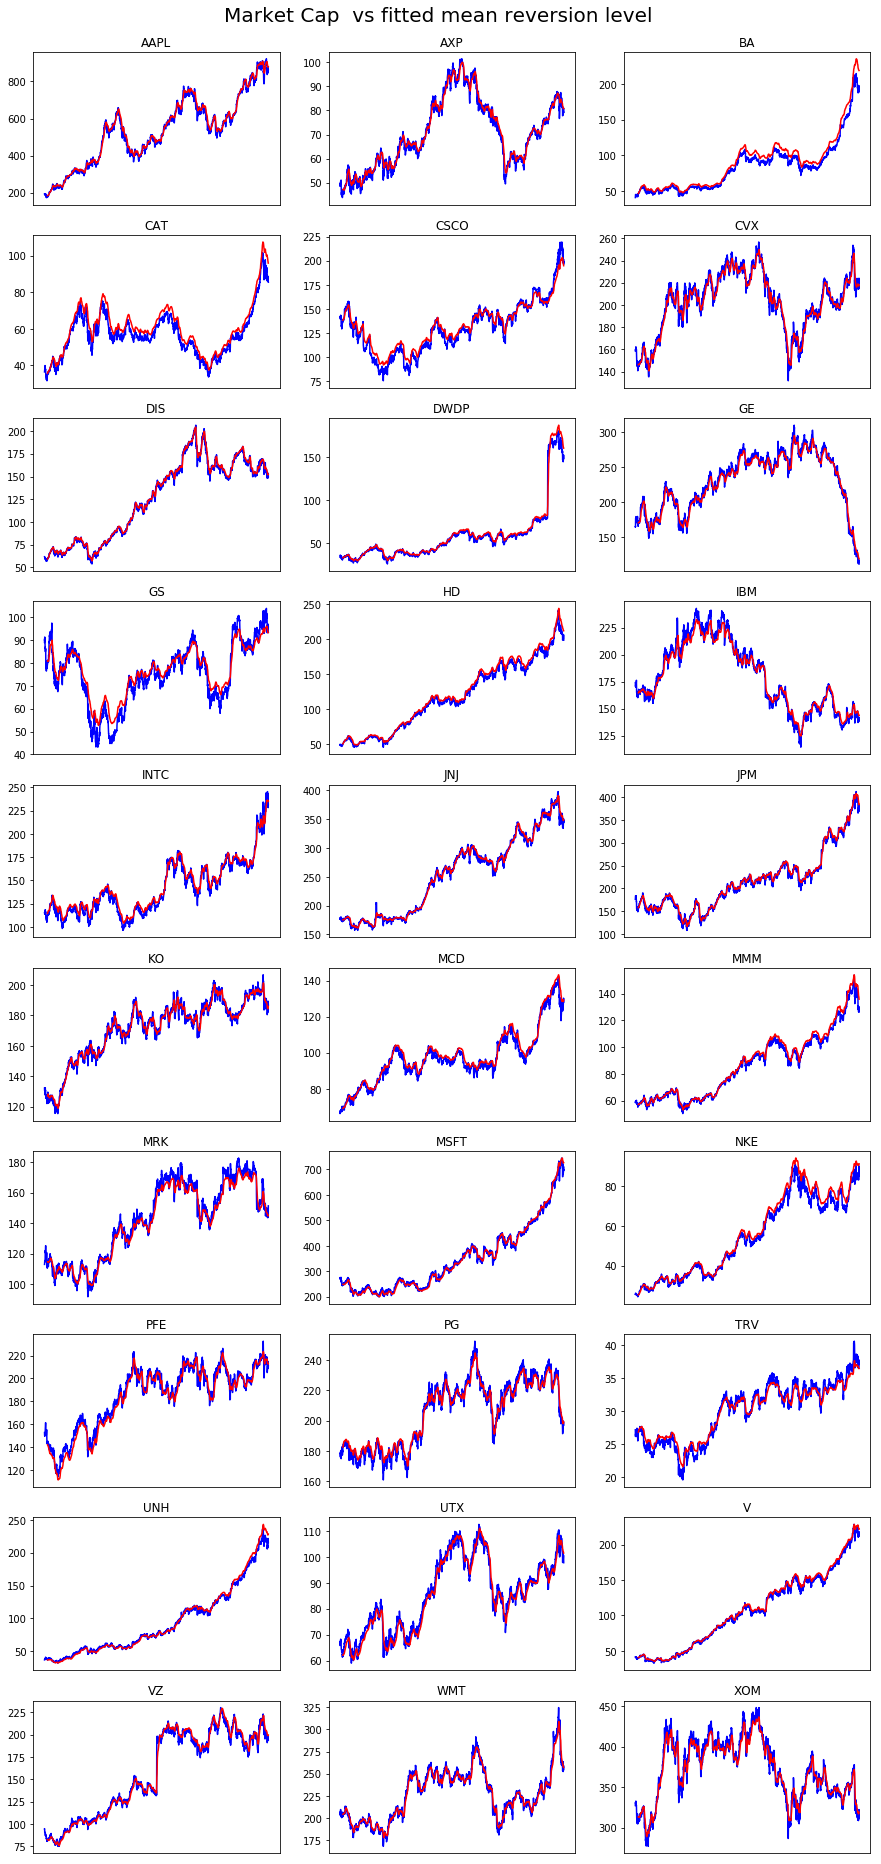

In [69]:
data = df_cap
theta = mean_levels
start_date='2010-01-01'
end_date='2017-12-31'
nplot = 30
scale = 1
title = 'Market Cap '

avg_mkt_cap = data.sum(axis=1).mean() # average market cap over the period

N = data.shape[1]


if N > nplot: N = nplot

plt.figure(figsize=(15,N))
plt.suptitle(title + ' vs fitted mean reversion level',size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = data.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*(1/1e9)*data.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot(scale*(avg_mkt_cap/1e9)*theta.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])
    

plt.show()

### Part 1 - Interpreation 
The plots are for the market capitalization of 30 stocks from DJI alongside their fitted mean reversion levels over an 8-year period, using the short and long moving averages as signals  

Market Capitalization (Blue Line):

The blue line represents the actual market capitalization of each stock over the specified period. It shows how the market cap has fluctuated over 8 years.

Mean Reversion Level (Red Line):

The red line represents the fitted mean reversion level for each stock. This line is a prediction or model output indicating the level to which the stock's market cap is expected to revert over 8 years.

By comparing the blue and red lines, you see how closely the actual market cap follows the predicted mean reversion level. These plots above illustrates the effectiveness and accuracy of the mean reversion model in capturing the inherent trends in stock market capitalizations.

## Part 2: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


## Benefits of Using Exponential Weighted Moving Averages

1. Responsive to Recent Data: More weight on recent prices for timely signals.
2. Reduced Lag: Quicker reaction to price changes.
3. Smoothing Volatility: Balances smoothness with sensitivity.
4. Better for Volatile Markets: Adapts well to volatility.
5. Customizable: Adjustable smoothing factor for different strategies.
6. Widely Used in Technical Indicators: Basis for many technical indicators.
7. Effective in Risk Management: Useful for trailing stops and dynamic position sizing.

By leveraging the benefits of EWMAs, traders and analysts can improve the accuracy and effectiveness of their trading strategies, particularly in dynamic and volatile markets.

In [70]:
# define the window sizes for two different exponential weighted moving 
# averages (EWMAs). In financial time series analysis, EWMAs are used to 
# smooth data and give more weight to recent observations. 
# Also use 2 years instead of 3 years as was the above part
exp_wgt_mov_avg_short_window = 7
exp_wgt_mov_avg_long_window = 15

'''
Compute the exponential weighted moving average (EWMA) for the df_cap 
DataFrame using the specified window sizes

EWMAs are useful for smoothing time series data to identify underlying 
trends and reduce noise. The span parameter determines the degree of 
smoothing, with a smaller span providing less smoothing and a larger span 
providing more smoothing.
'''
exp_wgt_mov_avg_short = df_cap.ewm( span = exp_wgt_mov_avg_short_window,
                                              adjust = False ).mean()
exp_wgt_mov_avg_long = df_cap.ewm( span = exp_wgt_mov_avg_long_window,
                                             adjust = False ).mean()

In [71]:
#print (df_cap.head().T)
#print (exp_wgt_mov_avg_long.head().T)

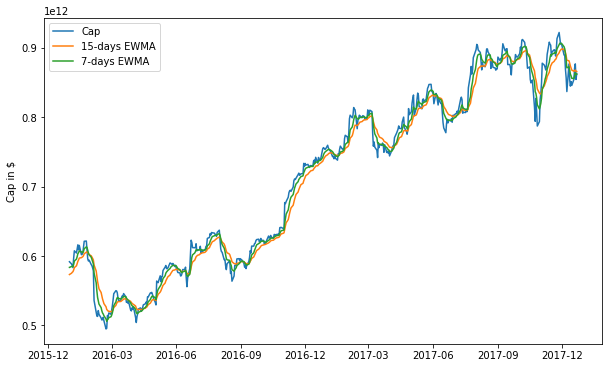

In [72]:
ticker = 'AAPL'
start_date = '2016-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(exp_wgt_mov_avg_long.loc[start_date:end_date, :].index, exp_wgt_mov_avg_long.loc[start_date:end_date, 'AAPL'], 
            label = '%d-days EWMA' % exp_wgt_mov_avg_long_window)
ax.plot(exp_wgt_mov_avg_short.loc[start_date:end_date, :].index, exp_wgt_mov_avg_short.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days EWMA' % exp_wgt_mov_avg_short_window)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

### Data preparation

In [73]:
# Manipulate raw data
# NOTE: .sum() has axis 1 because we want the sum of the column which is just
#       1 ticker symbol.
#       .mean() will then take the mean average of all the ticker symbol 
average_market_cap = df_cap.sum(axis=1).mean()

# Average
short_ewma_average = exp_wgt_mov_avg_short / average_market_cap
long_ewma_average = exp_wgt_mov_avg_long / average_market_cap
df_cap_average = df_cap / average_market_cap
#
# Because both heads for the long and short de-meaned pandas Dataframes have NaN 
# (Not-a-number.), Going to only start with the first valid number
# Using .first_valid_index
#Divide the normalized rolling averages by their values at the first valid index to set the initial value to 1. 
# This allows the series to be compared relative to its initial value. 
#This standardization simplifies visual comparisons and calculations, particularly when dealing with multiple series
# with different starting values or scales.

short_ewma_average_first_valid = (short_ewma_average 
                                    /
                                    short_ewma_average.loc[ short_ewma_average.first_valid_index() ])
long_ewma_average_first_valid = (long_ewma_average
                                   /
                                   long_ewma_average.loc[ long_ewma_average.first_valid_index() ])

# De-mean Rolling Averages
# Calculating percentage changes and shifting aligns the percentage changes with their periods, 
# providing a view of the relative changes over time.
# Demeaning helps to highlight deviations and short-term dynamics by removing 
# the trend component, making it easier to analyze the inherent fluctuations 
# and changes in the time series data
short_ewma_demeaned = short_ewma_average_first_valid.pct_change(periods=1).shift(-1)
long_ewma_demeaned = long_ewma_average_first_valid.pct_change(periods=1).shift(-1)

In [74]:

'''
Use RSI as a signal
df_returns = df_cap.pct_change()

# Calculate RSI for each component
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Calculate RSI for each column
df_rsi = df_returns.apply(lambda x: calculate_RSI(x))
print(df_rsi.head())
'''

'\nUse RSI as a signal\ndf_returns = df_cap.pct_change()\n\n# Calculate RSI for each component\ndef calculate_RSI(series, period=14):\n    delta = series.diff()\n    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()\n    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()\n    RS = gain / loss\n    RSI = 100 - (100 / (1 + RS))\n    return RSI\n\n# Calculate RSI for each column\ndf_rsi = df_returns.apply(lambda x: calculate_RSI(x))\nprint(df_rsi.head())\n'

In [75]:
# Clean data

# Drop last row
market_cap = df_cap_average[:-1]

# Drop not-a-numbers
signal_1 = short_ewma_demeaned.copy()
signal_2 = long_ewma_demeaned.copy()
#
signal_1 = signal_1.dropna()
signal_2 = signal_2.dropna()

# # Get rid rows where dates that do not match
market_cap = market_cap[ market_cap.index.isin(signal_1.index) & market_cap.index.isin(signal_2.index)]
signal_1 = signal_1[signal_1.index.isin( market_cap.index )]
signal_2 = signal_2[signal_2.index.isin( market_cap.index )]

In [76]:
# Get the amount of time steps
t = market_cap.shape[0]
t

2079

In [77]:
# Get the number of stocks
n = market_cap.shape[1]
n

30

### Calibrate with Tensorflow

In [78]:
start_date = '2010-1-1'
end_date = '2017-12-31'

# Only get the dates required
market_cap_required = market_cap.loc[ start_date : end_date ]
signal_1_required = signal_1.loc[ start_date : end_date ]
signal_2_required = signal_2.loc[ start_date : end_date ]

# Mentioned in the instructions, 2 signals means k = 2
k = 2
# k = 4

In [79]:
# Creating a Pandas Dataframe to hold the results
results = pd.DataFrame( [],
                        index = market_cap_required.columns,
                        columns = [ 'kappa',
                                    'sigma',
                                    'sigma^2',
                                    'w1',
                                    'w2'] )


In [80]:
# Tensorflow graph
tf.reset_default_graph()

# Input
x = tf.placeholder( shape = (None, n),
                    dtype = tf.float32,
                    name = 'x' )

# Signals
z1  = tf.placeholder( shape = (None,n),
                      dtype = tf.float32,
                      name = 'z1' ) 
z2  = tf.placeholder( shape = ( None, n),
                      dtype=tf.float32,
                      name = 'z2' )

# Variables
N_k = n
N_s = n
N_w = n
kappa = tf.get_variable( "kappa",
                         initializer = tf.random_uniform(
                                             [N_k], 
                                             minval = 0.0,
                                             maxval = 1.0) )
sigma = tf.get_variable( "sigma",
                         initializer = tf.random_uniform( 
                                             [N_s],
                                             minval=0.0,
                                             maxval=0.1) )

# Weights
#-------------------
w1_init = tf.random_normal( [N_w],
                            mean=0.5,
                            stddev=0.1 )
w2_init = 1 - w1_init
w1 = tf.get_variable( "w1",
                      initializer = w1_init)
w2 = tf.get_variable( "w2",
                      initializer=w2_init )

W1 = w1*tf.ones(n)
W2 = w2*tf.ones(n)


# Gaussian
#-------------------
mu    = tf.zeros( [n] )
Sigma = sigma*tf.ones( [n] )
theta1 = tf.multiply( W1,
                      z1)
theta2 = tf.multiply( W2,
                      z2)
scale  = tf.slice( x,
                   [0,0],
                   [1,-1] )
theta  = tf.multiply( scale,
                      tf.cumprod( 1 + tf.add( theta1,
                                              theta2) ) )

Kappa = kappa*tf.ones( [n] )

r = tf.divide( tf.subtract( tf.manip.roll( x,
                                           shift = -1,
                                           axis = 0),
                            x),
               x)
v = tf.subtract( r, 
                 tf.multiply( Kappa,
                              tf.subtract( theta,
                                           x) ) )
# NOTE: Do not use last row
vuse = tf.slice( v,
                 [0,0],
                 [tf.shape(v)[0]-1,-1] )

#  Constraint - No negative
#-------------------
clip_w1 = w1.assign(tf.maximum(0., w1))
clip_w2 = w2.assign(tf.maximum(0., w2))
clip = tf.group(clip_w1, clip_w2)

dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
log_prob = dist.log_prob(vuse)
reg_term = tf.reduce_sum(tf.square(w1+w2-1))
neg_log_likelihood = -tf.reduce_sum(log_prob) + 0.01*reg_term

# Optimizer
#-------------------
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize( neg_log_likelihood )

In [81]:
max_iteration = 5000
tolerence = 1e-15

### Execute the IRL model

In [82]:
# Save Tensorflow model because running the weight
saver = tf.train.Saver()

# Run Tensorflow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    losses = sess.run([neg_log_likelihood], feed_dict={x: market_cap_required, z1: signal_1_required, z2: signal_2_required})
    i=1
    
    # Calibrate print out
    print( "------------------- Calibration Calculating ----------------------" )
    print(" iter |       Loss       |   difference")
    
    while True:

        sess.run(train_op, feed_dict={x: market_cap_required, z1: signal_1_required, z2: signal_2_required})
        sess.run(clip) # force weights to be non-negative

        # update loss
        new_loss = sess.run(neg_log_likelihood, feed_dict={x: market_cap_required, z1: signal_1_required, z2: signal_2_required})
        loss_diff = np.abs(new_loss - losses[-1])
        losses.append(new_loss)

        if i%min(1000,(max_iteration/20))==1:
            print ("{:5} | {:16.4f} | {:12.4f}".format(i,new_loss,loss_diff))

        if loss_diff < tolerence:
            print('Loss function convergence in {} iterations!'.format(i))
            print('Old loss: {}  New loss: {}'.format(losses[-2],losses[-1]))
            break

        if i >= max_iteration:
            print('Max number of iterations reached without convergence.')
            break

        i += 1

    # Put data in pandas Dataframe.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)

    fitted_means = sess.run(theta, feed_dict={x: market_cap_required, z1: signal_1_required, z2: signal_2_required})
    mean_levels = pd.DataFrame(fitted_means,index=market_cap_required.index,columns=market_cap_required.columns)
    
    
    print( "------------------- Calibration Results ----------------------" )
    print(results.round(4))
    
    
    save_path = saver.save(sess, './part02_model.ckpt')
    print( 'Model saved in path: {}'.format(save_path) )

------------------- Calibration Calculating ----------------------
 iter |       Loss       |   difference
    1 |     -123773.9766 |     107.8594
  251 |     -151262.6250 |      91.8906
  501 |     -173903.3594 |      53.1562
Loss function convergence in 699 iterations!
Old loss: -180471.9375  New loss: -180471.9375
------------------- Calibration Results ----------------------
       kappa   sigma  sigma^2      w1      w2
AAPL  0.6417  0.0157   0.0002  0.4748  0.5308
AXP   0.2190  0.0148   0.0002  0.6477  0.3553
BA    0.6040  0.0151   0.0002  0.5541  0.5101
CAT   0.6933  0.0169   0.0003  0.7181  0.3349
CSCO  0.2811  0.0160   0.0003  0.5275  0.3469
CVX   0.7189  0.0133   0.0002  0.6444  0.3511
DIS   0.2487  0.0135   0.0002  0.4833  0.5425
DWDP  0.6864  0.0273   0.0007  0.4996  0.5579
GE    0.3579  0.0140   0.0002  0.5935  0.3999
GS    1.0566  0.0168   0.0003  0.5862  0.3104
HD    0.8672  0.0126   0.0002  0.4604  0.5570
IBM   0.0920  0.0124   0.0002  0.4462  0.3655
INTC  0.2443  0.0149

In [83]:
# Save the dataframe
results.to_csv('df_results_part02.csv')
results.to_csv('df_mean_levels_part02.csv')

### Plot Martket Cap against Fitted Mean Reversion Level
Purpose: Visualizes the market capitalization and its fitted mean reversion level for  30 stocks.
Layout: The plots are arranged in a grid, with each subplot showing the market cap and mean reversion level for an individual stock.
Scaling: Market capitalization is scaled to billions for clarity in the plots.

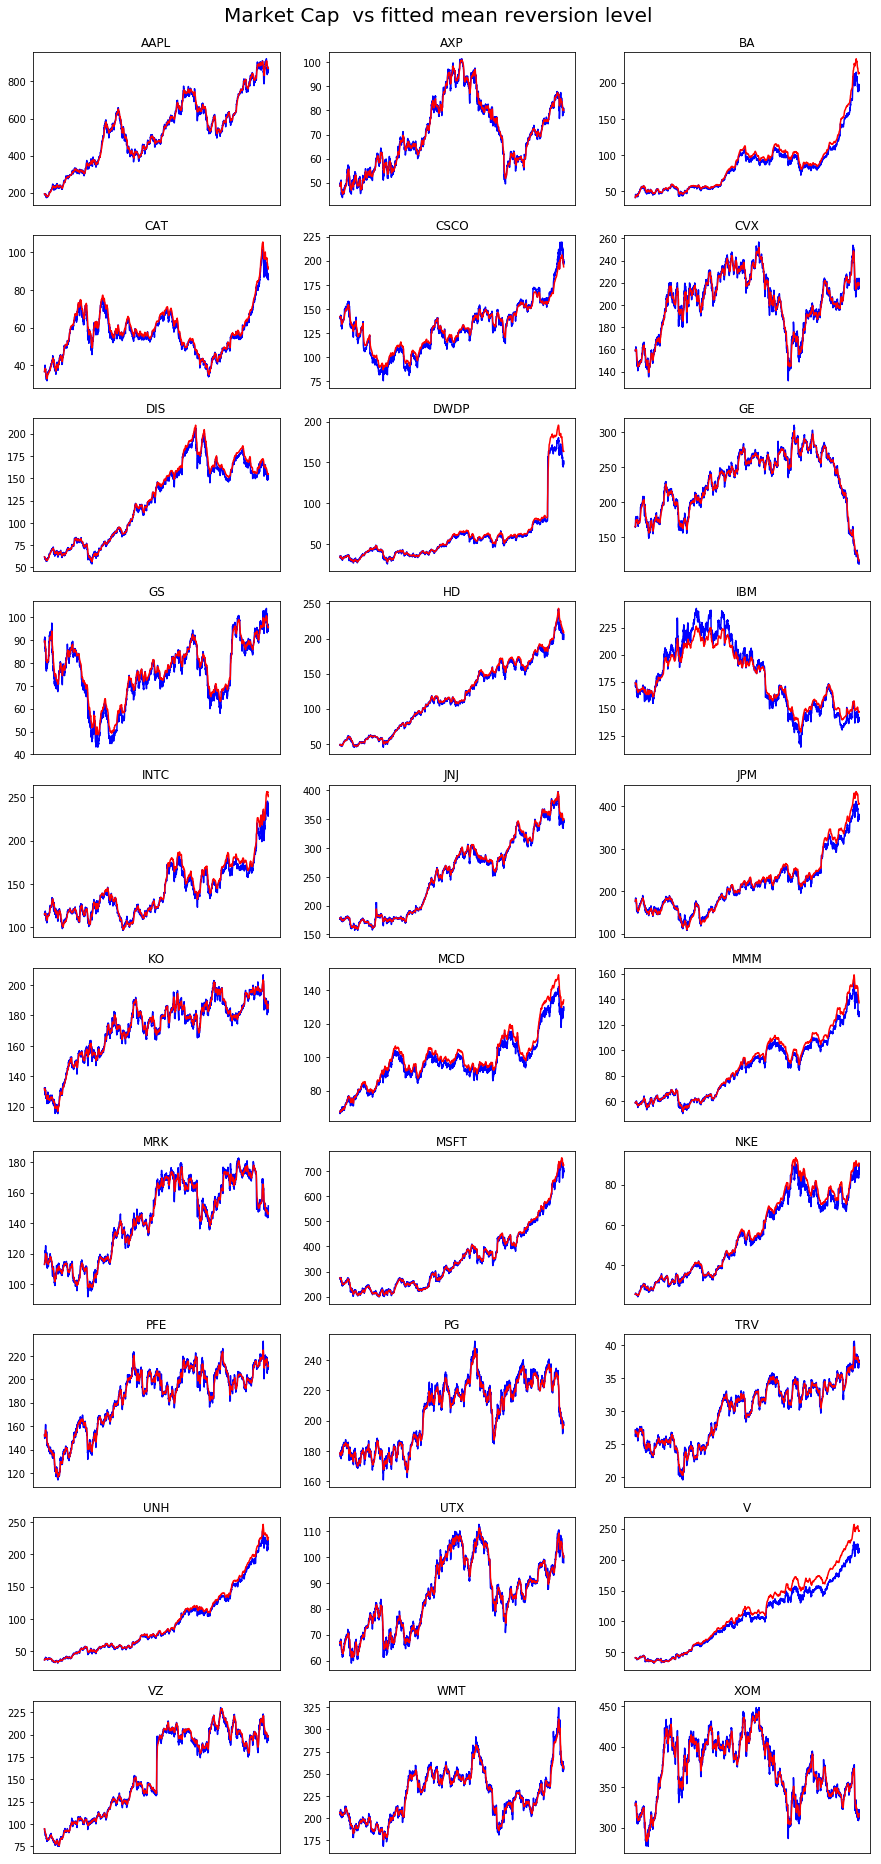

In [84]:
data = df_cap
theta = mean_levels
start_date='2010-01-01'
end_date='2017-12-31'
nplot = 30
scale = 1
title = 'Market Cap '

avg_mkt_cap = data.sum(axis=1).mean() # average market cap over the period

N = data.shape[1]


if N > nplot: N = nplot

plt.figure(figsize=(15,N))
plt.suptitle(title + ' vs fitted mean reversion level',size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = data.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*(1/1e9)*data.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot(scale*(avg_mkt_cap/1e9)*theta.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])
    


plt.show()

### Part 2 - Interpreation 
The plots are for the stock market capitalization of 30 stocks  from the DJI alongside their fitted mean reversion levels over an 8-year period, using the Exponential Weighted Moving Averages as signals.

Asset Prices (Blue Line):

The blue line represents the actual stock market caps of each stock over the specified period. It shows how the market cap has fluctuated over 8 years.

Mean Reversion Level (Red Line):

The red line represents the fitted mean reversion level for each stock. This line is a prediction or model output indicating the level to which the asset price is expected to revert over 8 years.

By comparing the blue and red lines, you see how closely the actual stock market cap follows the predicted mean reversion level. These plots above illustrates the effectiveness and accuracy of the mean reversion model in capturing the inherent trends in asset prices.

## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

In [85]:
import os
# The file is stored in the folder of the lab environment in order to be used 
# in this part
# List files in the current directory
print(os.listdir('.'))

['spx_holdings_and_spx_closeprice.csv', 'checkpoint', 'd:\\data', 'dja_cap.csv', 'df_results_part1.csv', 'df_results_part01.csv', 'IRL_market_model_DJI_calibration_Coursera.ipynb', '.ipynb_checkpoints', 'df_mean_levels_part02.csv', 'part02_model.ckpt.meta', 'part02_model.ckpt.data-00000-of-00001', 'df_results_part3.csv', 'df_mean_levels_part1.csv', 'df_mean_levels_part01.csv', 'df_results_part02.csv', 'df_mean_levels_part3.csv', 'part02_model.ckpt.index']


In [86]:
# Read the csv file
file_path = 'spx_holdings_and_spx_closeprice.csv'

asset_prices = pd.read_csv(file_path)
# Rename the date column to take Date title
asset_prices = asset_prices.rename(columns={'Unnamed: 0': 'Date'})

# Convert 'Date' column to datetime
asset_prices['Date'] = pd.to_datetime(asset_prices['Date'], format='%m/%d/%Y')

asset_prices.set_index('Date',inplace=True)
asset_prices.head()


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,...,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,...,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,...,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,...,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,...,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


In [87]:
# Only the first 5 tickers will be used in this analysis
n_stocks_show = 5
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3506, 419)


,A,AA,AAPL,ABC,ABT
Date,,,,,
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968


In [88]:
# Choose only the first 5 tickers
asset_prices_focused = asset_prices.iloc[:, :n_stocks_show]
asset_prices_focused.head()

,A,AA,AAPL,ABC,ABT
Date,,,,,
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968


### Data Preparation

In [89]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10
short_rolling = asset_prices_focused.rolling(window=window_1).mean()
#print(short_rolling.head(20))

# Calculating the long-window (20 days) simple moving average

window_2 = 20
long_rolling = asset_prices_focused.rolling(window=window_2).mean()
long_rolling.tail()

,A,AA,AAPL,ABC,ABT
Date,,,,,
2013-12-16,38.701930,21.035000,78.068345,69.7225,37.5770
2013-12-17,38.784880,21.118985,78.328065,69.6825,37.5105
2013-12-18,38.930400,21.197370,78.551065,69.7195,37.4810
2013-12-19,39.068055,21.300390,78.761495,69.7340,37.4735
2013-12-20,39.170310,21.392215,78.960665,69.7355,37.4620


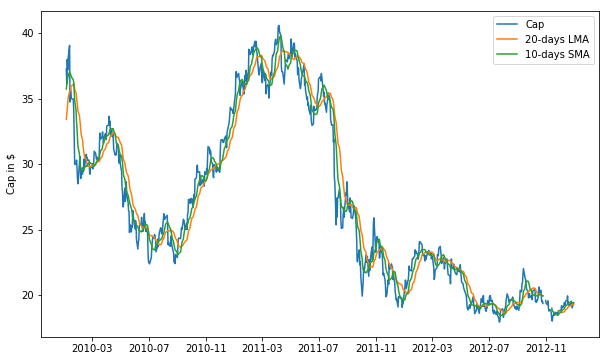

In [90]:
# The analysis will be for 3 years
ticker = 'AA'
start_date = '2010-01-01'
end_date = '2012-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(asset_prices_focused.loc[start_date:end_date, :].index, asset_prices_focused.loc[start_date:end_date, ticker], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, ticker], 
          label = '%d-days LMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, ticker], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

### Data Preparation

In [91]:
#Calculate Average Closing Price
average_closing_price = asset_prices_focused.sum(axis=1).mean() 

# Normalize Rolling Averages and original cap
short_rolling_average = short_rolling / average_closing_price
long_rolling_average = long_rolling / average_closing_price
asset_prices_average = asset_prices_focused / average_closing_price

#Divide the normalized rolling averages by their values at the first valid index to set the initial value to 1. 
# This allows the series to be compared relative to its initial value. 
#This standardization simplifies visual comparisons and calculations, particularly when dealing with multiple series
# with different starting values or scales.
short_rolling_average_first_valid = (short_rolling_average 
                                    /
                                    short_rolling_average.loc[ short_rolling_average.first_valid_index() ])
long_rolling_average_first_valid = (long_rolling_average
                                   /
                                   long_rolling_average.loc[ long_rolling_average.first_valid_index() ])


# De-mean Rolling Averages
# Calculating percentage changes and shifting aligns the percentage changes with their periods, 
# providing a view of the relative changes over time.
# Demeaning helps to highlight deviations and short-term dynamics by removing 
# the trend component, making it easier to analyze the inherent fluctuations 
# and changes in the time series data
short_rolling_demeaned = short_rolling_average_first_valid.pct_change(periods=1).shift(-1)
long_rolling_demeaned = long_rolling_average_first_valid.pct_change(periods=1).shift(-1)

### Data Cleaning

In [92]:
# Drop last row
# It removes the last row from the DataFrame to address alignment issues and 
# ensure consistent data length.
asset_price_av = asset_prices_average[:-1]

# Drop not-a-numbers rows
signal_1 = short_rolling_demeaned.copy()
signal_2 = long_rolling_demeaned.copy()
#
signal_1 = signal_1.dropna()
signal_2 = signal_2.dropna()

#Get rid rows where dates that do not match

asset_price_av = asset_price_av[ asset_price_av.index.isin(signal_1.index) & asset_price_av.index.isin(signal_2.index)]
# Ensures consistency and avoids data mismatches, which is essential for accurate analysis and valid calculations.
signal_1 = signal_1[signal_1.index.isin( asset_price_av.index )]
signal_2 = signal_2[signal_2.index.isin( asset_price_av.index )]

In [93]:
# Get the amount of time steps
t = asset_price_av.shape[0]
print(t)

# Get the number of stocks
n = asset_price_av.shape[1]
print(n)

3400
5


### Caliberate the tensorflow

In [94]:
start_date = '2011-1-1'
end_date = '2012-12-31'

# Retrieves the required dates 
asset_prices_required = asset_prices_focused.loc[ start_date : end_date ]
signal_1_required = signal_1.loc[ start_date : end_date ]
signal_2_required = signal_2.loc[ start_date : end_date ]

# 2 signals means k = 2
k = 2

# Creating a Pandas Dataframe to hold the results
results = pd.DataFrame( [],
                        index = asset_prices_required.columns,
                        columns = [ 'kappa',
                                    'sigma',
                                    'sigma^2',
                                    'w1',
                                    'w2'] )



In [95]:
# Indices in df1 but not in df2
indices_diff_1 = asset_prices_required.index.difference(signal_2_required.index)
print("Indices in asset_prices_required but not in signal_2_required:")
print(indices_diff_1)


Indices in asset_prices_required but not in signal_2_required:
DatetimeIndex(['2012-10-26', '2012-10-29', '2012-10-30', '2012-10-31',
               '2012-11-01', '2012-11-02', '2012-11-05', '2012-11-06',
               '2012-11-07', '2012-11-08', '2012-11-09', '2012-11-12',
               '2012-11-13', '2012-11-14', '2012-11-15', '2012-11-16',
               '2012-11-19', '2012-11-20', '2012-11-21', '2012-11-23',
               '2012-11-26', '2012-11-27'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [96]:
# Drop the specified indices
asset_prices_required = asset_prices_required.drop(indices_diff_1)

### Prepare the IRL Model

In [97]:
# Tensorflow graph defines a model that includes placeholders for input data, 
#variables for weights and parameters, and a Gaussian distribution-based loss 
# function. 
tf.reset_default_graph()

# Input: Using placeholders effectively enables dynamic input sizes and is crucial for building and training machine learning models in TensorFlow.
x = tf.placeholder( shape = (None, n),
                    dtype = tf.float32,
                    name = 'x' )

# Signals Placeholders (can add more signals here)
z1  = tf.placeholder( shape = (None,n),
                      dtype = tf.float32,
                      name = 'z1' ) 
z2  = tf.placeholder( shape = ( None, n),
                      dtype=tf.float32,
                      name = 'z2' )


# Variables
'''
kappa and sigma help in refining the reward function in IRL by adjusting its 
sensitivity and accounting for uncertainties, thus leading to more accurate 
and realistic models of the observed behavior.
'''
N_k = n # Represents the dimension for the kappa variable (used to scale or regularize the reward function, adjusting its magnitude or influencing its properties)
N_s = n #Represents the dimension for the sigma variable (define the variance or uncertainty in a probabilistic model)
N_w = n #Represents the dimension for the weights w1 and w2.
kappa = tf.get_variable( "kappa",
                         initializer = tf.random_uniform(
                                             [N_k], 
                                             minval = 0.0,
                                             maxval = 1.0) )

#This setup allows kappa to be a flexible parameter that can adjust how 
# different parts of the model interact, which can be crucial for tuning 
# and optimizing the model's performance.
sigma = tf.get_variable( "sigma",
                         initializer = tf.random_uniform( 
                                             [N_s],
                                             minval=0.0,
                                             maxval=0.1) )

#This setup allows sigma to play a crucial role in controlling the variability 
#and uncertainty in the model, which is important for accurate probabilistic 
#modeling and handling of noisy data.

# Weights
# Provides flexibility in adjusting and controlling the model’s behavior, combining different strategies, and enforcing constraints.
# w1 and w2 each hold a set of weights, each of which is a single value drawn from a normal distribution.
w1_init = tf.random_normal( [N_w],
                            mean=0.5,
                            stddev=0.1 )
w2_init = 1 - w1_init
w1 = tf.get_variable( "w1",
                      initializer = w1_init)
w2 = tf.get_variable( "w2",
                      initializer=w2_init )

W1 = w1*tf.ones(n)
W2 = w2*tf.ones(n)
'''
Purpose: The line W1 = w1 * tf.ones(n) creates a tensor W1 that is essentially a copy of w1. This is used to ensure uniform scaling or to maintain consistent tensor shapes.
Broadcasting: Ensures that operations are applied element-wise and can handle varying tensor shapes.
Practical Use: While the specific operation might seem redundant in this case, it is a foundational concept for tensor operations and broadcasting in TensorFlow.
'''

# Gaussian
#-------------------
# Zero initialization means that initially, the parameter will have no effect (neutral impact) on the operations that use this tensor until updated through training or further operations.
mu    = tf.zeros( [n] )
Sigma = sigma*tf.ones( [n] )

#This operation scales the signals z1, z2 by the weights in W1, W2 respectively, 
#  adjusting the influence of each feature in the model
theta1 = tf.multiply( W1,
                      z1)
theta2 = tf.multiply( W2,
                      z2)
#  extracting a reference or baseline row, which can be used for normalization or scaling in subsequent operations.
scale  = tf.slice( x,
                   [0,0],
                   [1,-1] ) # This tensor will contain the first row of x

# Theta represents the parameters of a reward function. 
theta  = tf.multiply( scale,
                      tf.cumprod( 1 + tf.add( theta1,
                                              theta2) ) )

#Kappa (κ) typically represents a parameter that influences the model dynamics or the reward function estimation. 
Kappa = kappa*tf.ones( [n] )

#computing the relative change 𝑟 between consecutive elements in the tensor 𝑥
r = tf.divide( tf.subtract( tf.manip.roll( x,
                                           shift = -1,
                                           axis = 0),
                            x),
               x)
'''
In the context of reinforcement learning (IRL), this folliwng function is part of a larger optimization or learning process. Here’s what each component represents:
Relative Change r: Represents the observed change between consecutive states or values.
Term theta−x: Represents a difference or residual between a model prediction or estimate (theta) and the actual state (x).
Scaling Factor Kappa: Adjusts the influence of the residual term on the final calculation.
'''
v = tf.subtract( r, 
                 tf.multiply( Kappa,
                              tf.subtract( theta,
                                           x) ) )
# NOTE: Do not use last row
vuse = tf.slice( v,
                 [0,0],
                 [tf.shape(v)[0]-1,-1] ) # extracts a sub-tensor from v starting from the beginning and excluding the last row.

#  Constraint - No negative
#-------------------
# clips negative values in w1 to 0, ensuring all values are non-negative.
#To enforce constraints, ensure stability, Synchronous updates
clip_w1 = w1.assign(tf.maximum(0., w1))
clip_w2 = w2.assign(tf.maximum(0., w2))
clip = tf.group(clip_w1, clip_w2)

#computing likelihoods, and incorporating probabilistic reasoning in models.
dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)

# Computes the log probability of the tensor vuse under the multivariate normal distribution defined by dist.
# evaluating data likelihood, fitting models, and ensuring numerical stability in computations.
log_prob = dist.log_prob(vuse)

#Regularization terms are added to the loss function to penalize deviations from the desired constraints. This helps in guiding the optimization process towards solutions that satisfy the constraints.
reg_term = tf.reduce_sum(tf.square(w1+w2-1))

'''
Optimize the model parameters by minimizing this combined objective function, 
thereby fitting the model to the data while enforcing certain constraints on 
the parameters.
'''
neg_log_likelihood = -tf.reduce_sum(log_prob) + 0.01*reg_term

# Optimizer
#-------------------
# To optimize the model by minimizing the specified loss function using the Adam algorithm, 
# which adjusts parameters based on gradients and adaptive learning rates
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize( neg_log_likelihood )

In [98]:
max_iteration = 5000 # Defines the maximum number of iterations the algorithm will perform before stopping
tolerence = 1e-15 # Sets the convergence threshold to determine when the algorithm has achieved sufficient accuracy.

### Execute the IRL Model

In [99]:
# Save Tensorflow model because running the weight
saver = tf.train.Saver() #  save and restore variables during or after training

# Run Tensorflow
# Initialization, training, saving, restoring, and inference tasks are handled within a TensorFlow session
with tf.Session() as sess: #ensures automatic cleanup and efficient resource management
    sess.run(tf.global_variables_initializer()) # initialize all the variables in a TensorFlow graph
    
    #This approach allows you to compute the loss value based on specific input data, which is crucial for evaluating the performance of your model during training or testing.
    losses = sess.run([neg_log_likelihood], feed_dict={x: asset_prices_required, z1: signal_1_required, z2: signal_2_required})
    i=1
    
    # Calibrate print out
    print( "------------------- Calibration Calculation ----------------------" )
    print(" iter |       Loss       |   difference")
    
    while True:

        sess.run(train_op, feed_dict={x: asset_prices_required, z1: signal_1_required, z2: signal_2_required})
        sess.run(clip) # force weights to be non-negative

        # update loss
        new_loss = sess.run(neg_log_likelihood, feed_dict={x: asset_prices_required, z1: signal_1_required, z2: signal_2_required})
        loss_diff = np.abs(new_loss - losses[-1]) # Helps in monitoring the convergence of the optimization process. A smaller loss_diff indicates that the loss is stabilizing and the optimization is nearing convergence.
        losses.append(new_loss) # Keeps track of the loss values over iterations, which can be useful for plotting the loss history or for debugging purposes.

        # It provides periodic snapshots of the current state without flooding the output with too much information.
        if i%min(1000,(max_iteration/20))==1:
            print ("{:5} | {:16.4f} | {:12.4f}".format(i,new_loss,loss_diff))

        #stops the process when the change in loss is below a certain threshold, indicating that the algorithm has found a satisfactory solution or is no longer significantly improving
        if loss_diff < tolerence:
            print('Loss function convergence in {} iterations!'.format(i))
            print('Old loss: {}  New loss: {}'.format(losses[-2],losses[-1]))
            break

        if i >= max_iteration:
            print('Max number of iterations reached without convergence.')
            break

        i += 1

    # Put data in pandas Dataframe.
    # extracting and storing values from a TensorFlow session.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)

    #apply a trained model to new data and then format the results in a way that is easy to analyze and interpret.
    #  executing a TensorFlow session to retrieve predicted values and then organizing these values into a Pandas DataFrame
    fitted_means = sess.run(theta, feed_dict={x: asset_prices_required, z1: signal_1_required, z2: signal_2_required})
    mean_levels = pd.DataFrame(fitted_means,index=asset_prices_required.index,columns=asset_prices_required.columns)    
    
    print( "------------------- Calibration Results ----------------------" )
    print(results.round(4))
        
    #aves the current state of the TensorFlow model, including its variables,
    #to a file (part02_model.ckpt). This allows you to persist the trained 
    #model and resume or deploy it later.
    save_path = saver.save(sess, './part02_model.ckpt')
    print( 'Model saved in path: {}'.format(save_path) )

------------------- Calibration Calculation ----------------------
 iter |       Loss       |   difference
    1 |      639292.3750 |    4053.5000
  251 |      258430.0312 |     561.1875
  501 |      168154.7969 |     233.7812
  751 |      124109.5703 |     132.9062
 1001 |       97332.3750 |      86.8594
 1251 |       78961.7344 |      62.7344
 1501 |       65427.0625 |      45.4219
 1751 |       55302.0859 |      35.8125
 2001 |       47274.5195 |      29.1523
 2251 |       40741.4414 |      23.7227
 2501 |       35317.3555 |      19.4805
 2751 |       30740.8438 |      16.6445
 3001 |       26829.8516 |      14.3203
 3251 |       23453.2383 |      12.3105
 3501 |       20513.2930 |      11.2051
 3751 |       17936.0625 |       9.4902
 4001 |       15663.2236 |       8.7354
 4251 |       13650.5127 |       7.6133
 4501 |       11861.2109 |       6.6787
 4751 |       10266.0830 |       5.9844
Max number of iterations reached without convergence.
------------------- Calibration Results

In [100]:
# Save the dataframe
results.to_csv('df_results_part03.csv')
results.to_csv('df_mean_levels_part03.csv')


### Plot Asset Prices against Fitted Mean Reversion Level
Purpose: Visualizes the Asset Prices and its fitted mean reversion level for 5 stocks.
Layout: The plots are arranged in a grid, with each subplot showing the Asset Prices and mean reversion level for an individual stock.

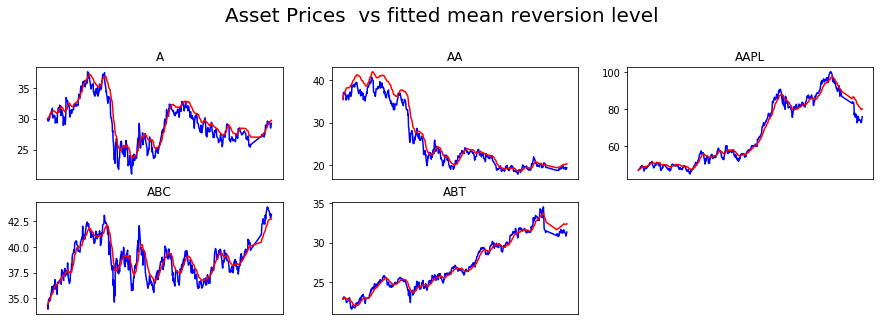

In [101]:

data = asset_prices_required
theta = mean_levels
start_date = '2011-1-1'
end_date = '2012-12-31'
nplot = 6
scale = 1
title = 'Asset Prices '

asset_price_av= data.sum(axis=1).mean() # average asset prices over the period

N = data.shape[1]


if N > nplot: N = nplot

plt.figure(figsize=(15,N))
plt.suptitle(title + ' vs fitted mean reversion level',size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = data.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(data.loc[start_date:end_date, stock], color='blue', label='Asset price ($)')
    plt.plot(theta.loc[start_date:end_date, stock], color='red', label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])
    

plt.show()

### Part 3 - Interpreation 
The plots are for the asset prices of 5 stocks  from the S&P500 alongside their fitted mean reversion levels over an 3-year period, using the short and long moving averages as signals.

Asset Prices (Blue Line):

The blue line represents the actual asset prices of each stock over the specified period. It shows how the market cap has fluctuated over 3 years.

Mean Reversion Level (Red Line):

The red line represents the fitted mean reversion level for each stock. This line is a prediction or model output indicating the level to which the asset price is expected to revert over 3 years.

By comparing the blue and red lines, you see how closely the actual asset price follows the predicted mean reversion level. These plots above illustrates the effectiveness and accuracy of the mean reversion model in capturing the inherent trends in asset prices.

## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


### Performance Metrics:

1. Mean Absolute Error (MAE): Calculate the MAE between the asset prices and the mean reversion levels.
2. R-squared: Evaluate how well the mean reversion model explains the variability of asset prices.

In [102]:
print(theta.head())

                    A         AA       AAPL        ABC        ABT
Date                                                             
2011-01-03  30.044146  35.758911  47.186996  34.382233  22.895208
2011-01-04  30.119762  36.130890  47.312790  34.460979  22.917185
2011-01-05  30.188158  36.432858  47.419384  34.554073  22.941370
2011-01-06  30.259499  36.720631  47.568069  34.636120  22.969408
2011-01-07  30.320242  37.029484  47.774899  34.702728  22.987497


### MAE

In [103]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assuming asset_prices_required and mean_levels are already defined
data = asset_prices_required
theta = mean_levels
start_date = '2011-01-01'  # Ensure correct date format
end_date = '2012-12-31'

# Reindex theta to align with data's date range
theta_aligned = theta.loc[start_date:end_date]

# Calculate absolute errors
absolute_errors = np.abs(data.loc[start_date:end_date] - theta_aligned)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data.loc[start_date:end_date].values.flatten(), theta_aligned.values.flatten())

print(f'Mean Absolute Error (MAE): {mae:.4f}')


Mean Absolute Error (MAE): 1.0258


### MAE : Interpretation

An MAE of 1.0177, given the price range of 27 to 42, suggests that the calculated mean reversion model has a reasonable level of accuracy. 


### R-squared

In [104]:
from sklearn.metrics import r2_score

# Extract relevant data
actual = data.loc[start_date:end_date]
predicted = theta.loc[start_date:end_date]

# Ensure same indices
actual, predicted = actual.align(predicted, join='inner')

# Calculate R-squared for each stock
r2_scores = {}
for stock in actual.columns:
    r2_scores[stock] = r2_score(actual[stock], predicted[stock])

# Print R-squared values
for stock, r2 in r2_scores.items():
    print(f"{stock}: R-squared = {r2:.4f}")


A: R-squared = 0.8591
AA: R-squared = 0.9375
AAPL: R-squared = 0.9788
ABC: R-squared = 0.8347
ABT: R-squared = 0.9794


### R-squared: Interpretation

As the values of the R-squared for all 5 stocks approaches to 1 unit (ranges from strong (.8154) to exceptional (.9794), means that the model almost explains and captures all the variability in the data.

### Overall Evaluation

The model appears to be performing well, as indicated by the high R² values and the reasonable MAE. This suggests that the mean reversion model is a good predictor of asset prices for the stocks under analysis.